# Logbook

In [3]:
1/(2.6e-4*9.81)

392.06461224809846

In [4]:
import sys
import os
from netCDF4 import Dataset
import xarray as xr
import numpy as np
sys.path.append('..')
import matplotlib.pyplot as plt
from src.data import nc_to_obs

In [5]:
filename = os.path.join('..', 'obs', 'les_Bruno', 'outdir_0005', 'profiles.nc')
params_filename = os.path.join('..', 'obs', 'les_Bruno', 'outdir_0005', 'profiles.json')

obs = nc_to_obs(filename, params_filename)
obs

Obs(
  variables=<xarray.Dataset> Size: 2MB
Dimensions:  (t: 241, z: 256)
Coordinates:
  * t        (t) float64 2kB 0.0 3.6e+03 7.2e+03 ... 8.604e+05 8.64e+05
  * z        (z) float64 2kB -598.8 -596.5 -594.1 ... -5.859 -3.516 -1.172
Data variables:
    u        (t, z) float64 494kB 0.0 0.0 0.0 0.0 ... 0.0327 0.09213 0.2224
    v        (t, z) float64 494kB 0.0 0.0 0.0 0.0 ... -0.1424 -0.1584 -0.1813
    temp     (t, z) float64 494kB 19.3 19.3 19.3 19.3 ... 19.91 19.91 19.91
    salt     (t, z) float64 494kB 35.0 35.0 35.0 35.0 ... 35.0 35.0 35.0 35.0,
  parameters=typing.Any,
  metadatas=None
)

In [6]:
temp = obs.variables.temp
temp.values

array([[19.29566193, 19.29841805, 19.30117416, ..., 19.99310875,
        19.99586296, 19.99861526],
       [19.29480553, 19.29806137, 19.3009243 , ..., 19.99333382,
        19.99532509, 19.99582863],
       [19.29483032, 19.29802322, 19.30092812, ..., 19.98801422,
        19.98926926, 19.99014664],
       ...,
       [19.29587173, 19.29861259, 19.3012867 , ..., 19.91279602,
        19.91252708, 19.9119854 ],
       [19.2958622 , 19.29858017, 19.30124092, ..., 19.91268158,
        19.91242027, 19.91189384],
       [19.29585648, 19.29856873, 19.30122185, ..., 19.91259384,
        19.91233635, 19.91181564]])

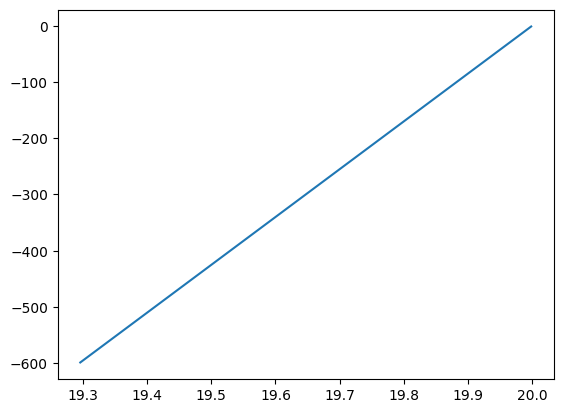

In [7]:
plt.plot(temp[0, :], temp.z)

<KeysViewHDF5 ['Ri', 'T', 'TT', 'b', 'bT', 'e', 'p', 't', 'u', 'uT', 'ub', 'uu', 'uv', 'v', 'vT', 'vb', 'vv', 'wT', 'wb', 'wu', 'wv', 'ww', 'κₑ_∂z_T', 'νₑ_∂z_u', 'νₑ_∂z_v', 'νₑ_∂z_w']>


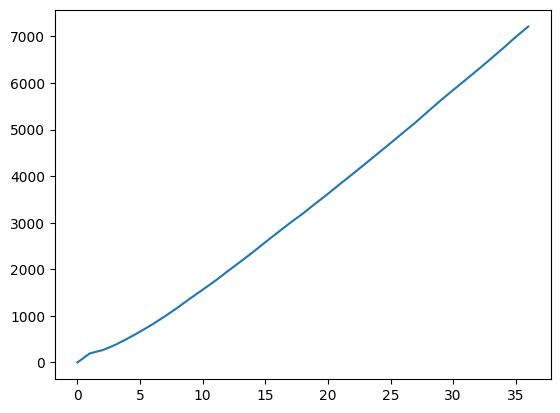

In [46]:
import h5py

filename_j = os.path.join('..', 'obs', 'horizontally_averaged_LES_data',
                        '6_hour_suite', '0.75m', 'free_convection_instantaneous_statistics.jld2')

def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print(f"    {key}: {val}")


f = h5py.File(filename_j, 'r')
# f.visititems(print_attrs)

ts = f['timeseries']
print(ts.keys())

t = ts['t']['0']
time_list_str = list(ts['t'].keys())

time_list = [int(time) for time in time_list_str]
time_list.sort()
plt.plot(time_list)
# plt.plot(T['4051'][:, 0, 0])



# jld2 -> netcdf

In [77]:
import h5py
import os
import numpy as np
import xarray as xr
from pathlib import Path
from netCDF4 import Dataset


def list_files_dir(directory):
    dir_path = Path(directory)
    files = [f for f in dir_path.rglob('*') if f.is_file() and f.name.endswith('.jld2')]
    return files

def p(name, obj):
    print(name)
    if isinstance(obj, h5py.Dataset):
        print(obj[()])

def jld2_to_nc(jld2_file_path, nc_file_path):
    # ouverture des fichiers
    jl = h5py.File(jld2_file_path, 'r')
    if os.path.exists(nc_file_path):
        os.remove(nc_file_path)
    nc = Dataset(nc_file_path, 'w', format='NETCDF4')

    # dimensions
    times_str = list(jl['timeseries']['T'].keys())
    del l[-1]
    t = [int(i) for i in times_str[:-1]]
    t.sort()
    zw = jl['grid']['zᵃᵃᶠ'][3:-3]
    zr = jl['grid']['zᵃᵃᶜ'][3:-3]
    nc.createDimension('t', len(t))
    nc.createDimension('zw', len(zw))
    nc.createDimension('zr', len(zr))
    t_nc = nc.createVariable('t', np.float64, ('t',))
    zw_nc = nc.createVariable('zw', np.float64, ('zw',))
    zr_nc = nc.createVariable('zr', np.float64, ('zr',))
    t_nc[:] = t
    zw_nc[:] = zw
    zr_nc[:] = zr

    # fermeture des fichiers
    jl.close()
    nc.close()
    

greg_path = os.path.join('..', 'obs', 'horizontally_averaged_LES_data')

greg_files_paths = list_files_dir(greg_path)

jld2_file_path = greg_files_paths[0]

nc_file_path = jld2_file_path.with_suffix('.nc')

jld2_to_nc(jld2_file_path, nc_file_path)

xr.open_dataset(nc_file_path)




[0, 196, 261, 301, 331, 365, 393, 419, 446, 474, 503, 533, 563, 594, 625, 656, 687, 719, 751, 783, 815, 847, 879, 911, 944, 977, 1010, 1043, 1076, 1110, 1144, 1177, 1211, 1245, 1278, 1309, 1340, 1372, 1404, 1435, 1467, 1499, 1531, 1563, 1593, 1623, 1652, 1680, 1708, 1737, 1765, 1794, 1823, 1851, 1878, 1904, 1930, 1956, 1981, 2006, 2031, 2056, 2080, 2105, 2129, 2155, 2180, 2204, 2228, 2251, 2274, 2297, 2321, 2345, 2370, 2396, 2421, 2445, 2469, 2492, 2515, 2538, 2562, 2585, 2608, 2632, 2656, 2680, 2704, 2729, 2753, 2779, 2806, 2835, 2863, 2891, 2918, 2945, 2972, 2999, 3027, 3056, 3083, 3110, 3137, 3165, 3193, 3222, 3252, 3282, 3313, 3345, 3376, 3408, 3440, 3472, 3504, 3535, 3567, 3598, 3630, 3662, 3695, 3728, 3760, 3793, 3827, 3861, 3895, 3930, 3965, 4000, 4034, 4068, 4102, 4135, 4167, 4200, 4234, 4268, 4302, 4337, 4370, 4403, 4437]


<xarray.Dataset> Size: 2kB
Dimensions:  (t: 145, zw: 65, zr: 64)
Coordinates:
  * t        (t) float64 1kB 0.0 196.0 261.0 ... 4.37e+03 4.403e+03 4.437e+03
  * zw       (zw) float64 520B -256.0 -247.0 -238.5 -230.4 ... -6.158 -3.079 0.0
  * zr       (zr) float64 512B -251.5 -242.8 -234.5 ... -7.698 -4.618 -1.539
Data variables:
    *empty*

In [70]:
l = [1, 2, 3]
del l[-1]
l

[1, 2]